# Section 4 – Language Models exploration

In [1]:
import pandas as pd
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import time

## 4.1 Pretrain BERT

In [2]:
df_o = pd.read_parquet("ssh_attacks.parquet", columns=["full_session", "Set_Fingerprint"])
df_o['label_class'] = df_o['Set_Fingerprint'].apply(lambda x: '_'.join(map(str, x)))
class_counts = df_o['label_class'].value_counts()
df_o['label_class'] = df_o['label_class'].apply(lambda x: x if class_counts[x] >= 2 else 'rare_class') # bring rare Set_Fingerprint classes together before stratified split

_, df = train_test_split(
    df_o,
    test_size=0.1,
    stratify=df_o['label_class'],
    random_state=42
)
df = df.drop(columns=['label_class'])
df

,full_session,Set_Fingerprint
25936,"cat /proc/cpuinfo | grep name | wc -l ; echo ""...","[Discovery, Execution, Persistence]"
51422,"cat /proc/cpuinfo | grep name | wc -l ; echo ""...","[Discovery, Execution, Persistence]"
226037,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]"
191707,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]"
57550,"cat /proc/cpuinfo | grep name | wc -l ; echo ""...","[Discovery, Execution, Persistence]"
...,...,...
140211,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]"
1117,enable ; system ; shell ; sh ; cat /proc/mount...,"[Defense Evasion, Discovery]"
169832,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]"
154400,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]"


In [3]:
all_labels=['Persistence', 'Discovery', 'Defense Evasion', 'Execution', 'Impact', 'Other', 'Harmless']
# Binarize multi-labels
mlb = MultiLabelBinarizer(classes=all_labels)
df['encoded_labels'] = list(mlb.fit_transform(df['Set_Fingerprint'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)))


df

,full_session,Set_Fingerprint,encoded_labels
25936,"cat /proc/cpuinfo | grep name | wc -l ; echo ""...","[Discovery, Execution, Persistence]","[1, 1, 0, 1, 0, 0, 0]"
51422,"cat /proc/cpuinfo | grep name | wc -l ; echo ""...","[Discovery, Execution, Persistence]","[1, 1, 0, 1, 0, 0, 0]"
226037,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]","[1, 1, 0, 0, 0, 0, 0]"
191707,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]","[1, 1, 0, 0, 0, 0, 0]"
57550,"cat /proc/cpuinfo | grep name | wc -l ; echo ""...","[Discovery, Execution, Persistence]","[1, 1, 0, 1, 0, 0, 0]"
...,...,...,...
140211,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]","[1, 1, 0, 0, 0, 0, 0]"
1117,enable ; system ; shell ; sh ; cat /proc/mount...,"[Defense Evasion, Discovery]","[0, 1, 1, 0, 0, 0, 0]"
169832,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]","[1, 1, 0, 0, 0, 0, 0]"
154400,cat /proc/cpuinfo | grep name | wc -l ; echo -...,"[Discovery, Persistence]","[1, 1, 0, 0, 0, 0, 0]"


In [4]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # tokenizer is in charge of preparing the inputs for a model

class MultiLabelTextDataset(Dataset):
    def __init__(self, sessions, labels):
        self.sessions = sessions
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx): # executed at each batch to get each item, batch_size=8 -> gets 8 items at a time
        text = self.sessions[idx]
        encoded = tokenizer(text, padding='max_length', truncation=True, max_length=416, return_tensors="pt") # tokenize session text, until a length of 416 for the tensor generated from the pretrained vocabulary
        return encoded, self.labels[idx] # encoded labels and tokenized session body

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(df['full_session'], df['encoded_labels'], train_size=0.7, random_state=42, shuffle=True)

train_dataset = MultiLabelTextDataset(X_train.tolist(), y_train.tolist())
val_dataset = MultiLabelTextDataset(X_val.tolist(), y_val.tolist())

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
train_dataset[0]

<ipython-input-4-a383a5c8cd56>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.labels = torch.tensor(labels, dtype=torch.float32)


({'input_ids': tensor([[  101,  4937,  1013,  4013,  2278,  1013, 17368,  2378, 14876,  1064,
          24665, 13699,  2171,  1064, 15868,  1011,  1048,  1025,  9052,  1000,
           7117,  1024,  1051,  2509,  2098, 12541, 15042,  2100,  3501,  3270,
           1000,  1064, 10381, 15194, 21724,  1064, 24234,  1025,  9052,  1000,
          24030,  1000,  1028,  1013, 13075,  1013,  1056,  8737,  1013,  1012,
          13075,  2692, 19481, 19317, 12521,  2509,  1025, 28549,  1011, 21792,
           1013, 13075,  1013,  1056,  8737,  1013,  1012, 13075,  2692, 19481,
          19317, 12521,  2509,  1025,  4937,  1013, 13075,  1013,  1056,  8737,
           1013,  1012, 13075,  2692, 19481, 19317, 12521,  2509,  1064,  2132,
           1011,  1050,  1015,  1025,  4937,  1013,  4013,  2278,  1013, 17368,
           2378, 14876,  1064, 24665, 13699,  2171,  1064,  2132,  1011,  1050,
           1015,  1064, 22091,  2243,  1005,  1063,  6140,  1002,  1018,  1010,
           1002,  1019,  1

## 4.2 Add a Dense layer to the Model

In [6]:
class BertMultiLabelClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_labels=len(all_labels)):
        super(BertMultiLabelClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, num_labels) # takes the dimension of bert output for the linear layer

    # Forward pass
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # BERT model
        pooled_output = outputs.pooler_output  # [CLS] token embedding
        x = self.dropout(pooled_output) # Dropout
        logits = self.linear(x)  # Dense Layer. Raw logits
        return logits


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use of GPU/TPU for google colab

model = BertMultiLabelClassifier()
model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Multi-label loss
optimizer = optim.AdamW(
    model.parameters(),
    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Training Loop

In [9]:
N = 7  # Number of epochs
total_steps = len(train_loader) * N
print("total steps: ", total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

total steps:  5712


In [11]:
training_stats = []
# Measure the total training time for the whole run.
total_t0 = time.time()
for epoch in range(N):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, N))
    print('Training...')
    model.train()
    total_loss = 0.0

    for i, batch in enumerate(train_loader):
        # Print loss and time every 200 batches
        if (i + 1) % 100 == 0:
            elapsed_time = time.time() - total_t0
            print(f"Epoch [{epoch+1}/{N}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Time: {elapsed_time:.2f}s")

        encoded_inputs, labels = batch # batch = dictionary of tensors and a label tensor
        input_ids = encoded_inputs['input_ids'].squeeze(1).to(device)
        attention_mask = encoded_inputs['attention_mask'].squeeze(1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()


    avg_train_loss = total_loss / len(train_loader)  # Calculate average training loss

    # Append epoch statistics to training_stats
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
        }
    )


    # Validation Step
    model.eval()
    total_val_loss = 0.0
    all_preds, all_lab = [], []
    validation_stats = []

    with torch.no_grad():
        for batch in val_loader:
            encoded_inputs, labels = batch
            input_ids = encoded_inputs['input_ids'].squeeze(1).to(device)
            attention_mask = encoded_inputs['attention_mask'].squeeze(1).to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels.to(device))
            total_val_loss += loss.item()

            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            preds = (preds > 0.5).int()

            all_preds.append(preds.cpu())
            all_lab.append(labels.cpu())

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    # Append epoch statistics to validation_stats
    validation_stats.append(
        {
            'epoch': epoch + 1,
            'Validation Loss': avg_val_loss,
        }
    )

    print(f"Epoch {epoch+1}/{N}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")




end_time = time.time() # Record the end time of the training
train_duration = end_time - total_t0 # Calculate the training duration
print(f"Training completed in {train_duration:.2f} seconds.")



======== Epoch 1 / 7 ========
Training...
Epoch [1/7], Batch [100/816], Loss: 0.0993, Time: 139.55s
Epoch [1/7], Batch [200/816], Loss: 0.0313, Time: 283.67s
Epoch [1/7], Batch [300/816], Loss: 0.0460, Time: 428.04s
Epoch [1/7], Batch [400/816], Loss: 0.0431, Time: 572.33s
Epoch [1/7], Batch [500/816], Loss: 0.0463, Time: 716.57s
Epoch [1/7], Batch [600/816], Loss: 0.0406, Time: 860.59s
Epoch [1/7], Batch [700/816], Loss: 0.0230, Time: 1004.95s
Epoch [1/7], Batch [800/816], Loss: 0.0129, Time: 1148.94s
Epoch 1/7, Train Loss: 0.0499, Val Loss: 0.0201

======== Epoch 2 / 7 ========
Training...
Epoch [2/7], Batch [100/816], Loss: 0.0076, Time: 1499.36s
Epoch [2/7], Batch [200/816], Loss: 0.0311, Time: 1643.57s
Epoch [2/7], Batch [300/816], Loss: 0.0052, Time: 1787.75s
Epoch [2/7], Batch [400/816], Loss: 0.0123, Time: 1931.93s
Epoch [2/7], Batch [500/816], Loss: 0.0170, Time: 2076.16s
Epoch [2/7], Batch [600/816], Loss: 0.0044, Time: 2220.41s
Epoch [2/7], Batch [700/816], Loss: 0.0277, Ti

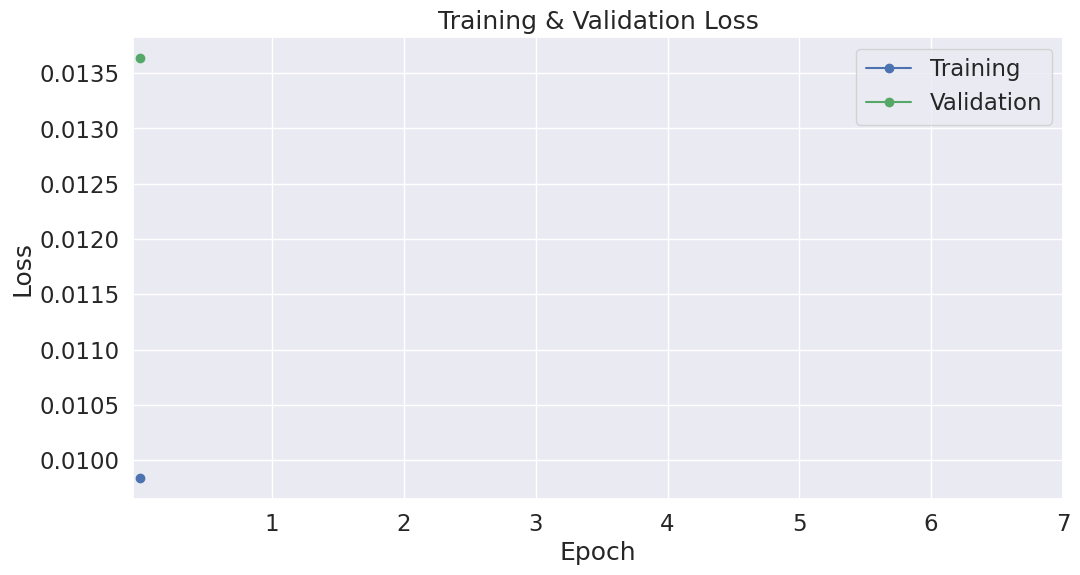

In [12]:
training_df = pd.DataFrame(training_stats)
validation_df = pd.DataFrame(validation_stats)
df_train_val = pd.merge(training_df, validation_df, on='epoch')


sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(training_df, 'b-o', label="Training")
plt.plot(validation_df, 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1, N + 1))

plt.show()

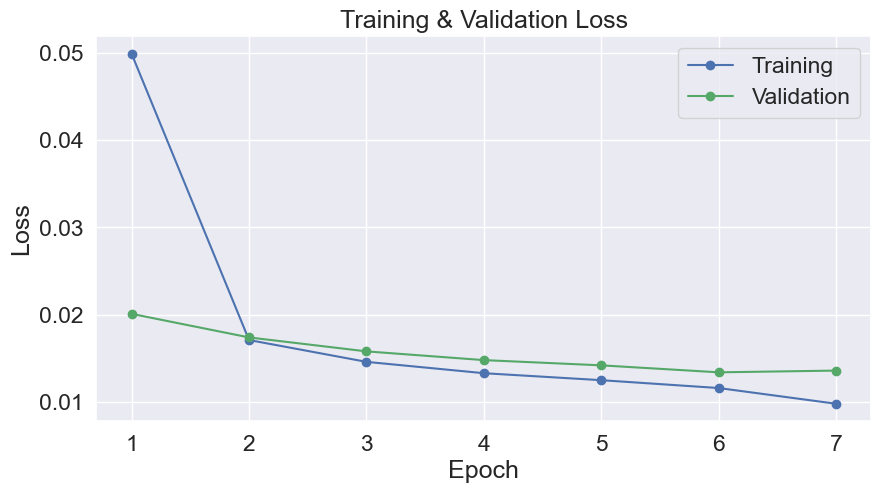

In [6]:
valid_data = [0.0201, 0.0174, 0.0158, 0.0148, 0.0142, 0.0134, 0.0136]
train_data = [0.0499, 0.0171, 0.0146, 0.0133, 0.0125, 0.0116, 0.0098]
x_values = list(range(1, 7 + 1))  # Generate x-values starting from 1
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the learning curve.
plt.plot(x_values, train_data, 'b-o', label="Training")
plt.plot(x_values, valid_data, 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1, 7 + 1))

plt.show()